In [1]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math,random,re
import time
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import LSTM, RepeatVector
from keras.layers import Input, Dense, Lambda, Dropout,Activation, TimeDistributed
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import regularizers
#Invariants
ORDER_KEY="XILVAGMFYWEDQNHCRKSTPBZ-"[::-1]
ORDER_LIST=list(ORDER_KEY)
%reload_ext autoreload
%autoreload 1
from helper_tools import *
from helper_tools_for_plotting import *
data=pdataframe_from_alignment_file("PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m",50000)
print ("number of data points: ",len(data))
data_set_size=len(data)
data.head()


Using TensorFlow backend.


number of data points:  50000


,name,sequence
0,PABP_YEAST/115-210,qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...
1,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/203-294,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKD...
2,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/534-625,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKD...
3,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/312-398,........IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVD...
4,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/33-112,........---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRD...


In [2]:
indices=index_of_non_lower_case_dot(data.iloc[0]["sequence"])
data["seq"]=list(map(prune_seq,data["sequence"]))
data.head()

,name,sequence,seq
0,PABP_YEAST/115-210,qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...,KGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGF...
1,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/203-294,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKD...,PKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKDENGNSRGF...
2,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/534-625,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKD...,PKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKDENGNSRGF...
3,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/312-398,........IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVD...,IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVDSQGQSKGS...
4,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/33-112,........---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRD...,---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRDIRRVSLGY...


In [3]:
PRUNED_SEQ_LENGTH=len(data.iloc[0]["seq"])
with open ("PABP_YEAST_hmmerbit_t0.2_r50000.reweight","rb") as to_read:
    new_weights=np.load(to_read)

#new_weights=reweight_sequences(data["seq"],0.1)
len(new_weights),new_weights[:10]
#Encode training data in one_hot vectors
training_data_one_hot=[]
labels=[]
for i, row in data.iterrows():
    training_data_one_hot.append(translate_string_to_one_hot(row["seq"],ORDER_LIST))
print (len(training_data_one_hot))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(training_data.shape)
exp_data_full=pd.read_csv(
    "PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
print ("number of mutants: ",len(exp_data_full))
exp_data_full.head()
exp_data_full.iloc[87]
exp_data_full.corr(method="spearman")
OFFSET=117
#Deciding offset requires investigating the dataset and alignment.
exp_data_singles=pd.DataFrame(columns=exp_data_full.columns)
#decide starting index depending on how the file is "headered"
for i,row in exp_data_full[1:].iterrows():
        pos=re.split(r'(\d+)', row.mutant) 
        if int(pos[1])-OFFSET in indices:
            exp_data_singles=exp_data_singles.append(row)
exp_data_singles=exp_data_singles.reset_index()
target_values_singles=list(exp_data_singles["linear"])
exp_data_singles.head(10) 

50000
(50000, 1968)
number of mutants:  1188


,index,mutant,effect_prediction_epistatic,effect_prediction_independent,linear
0,1,G126C,-5.663638,-0.027602,0.449027
1,2,G126E,-6.611062,-1.827612,0.588928
2,3,G126D,-7.270577,-1.180094,0.229853
3,4,G126N,-5.809167,0.387443,0.679435
4,5,G126S,-4.617248,0.661686,0.721788
5,6,G126R,-5.582381,1.144148,0.313690
6,7,G126W,-8.079901,-2.052391,0.226032
7,8,G126V,-5.435631,-0.800307,0.230315
8,9,N127A,-4.987206,-2.251823,0.062650
9,10,N127C,-8.044181,-2.215639,0.024996


In [4]:
mutation_data=[re.split(r'(\d+)', s) for s in exp_data_singles.mutant]#split the mutant coll e.g.N,126,C
wt_sequence=data.iloc[0].seq#wt:KGSGNIFIKNLHPDIDNKALYDTFSVFGDILSS
mutants=mutate_single(wt_sequence,mutation_data,offset=0,index=3) #note that you change index to 1

#sanity checks
print (len(mutants),len(exp_data_singles))
#the mutant should be in the correct place
print (list(zip(wt_sequence,mutants[3]))[:10])#change the index [3] G to N and pring the first 10 position of mutant
#Test data with wt at 0 index
one_hot_mutants=[]#encode each matant to one hot 
mutants_plus=[data.iloc[0]["seq"]]+mutants
for mutant in mutants_plus:
    one_hot_mutants.append(translate_string_to_one_hot("".join(mutant),ORDER_LIST))

test_data_plus=np.array([np.array(list(sample.flatten())).T for sample in one_hot_mutants])

1187 1187
[('K', 'K'), ('G', 'G'), ('S', 'S'), ('G', 'N'), ('N', 'N'), ('I', 'I'), ('F', 'F'), ('I', 'I'), ('K', 'K'), ('N', 'N')]


In [5]:
exp_data_full=pd.read_csv(
    "PABP_YEAST_Fields2013-doubles.csv", sep=";", comment="#"
)
print ("number of mutants: ",len(exp_data_full))
exp_data_full.head()
exp_data_full.iloc[0]
exp_data_full.corr(method="spearman")
OFFSET=160
#Deciding offset requires investigating the dataset and alignment.
exp_data_doubles=pd.DataFrame(columns=exp_data_full.columns)
#decide starting index depending on how the file is "headered"
for i,row in exp_data_full[0:].iterrows():
        pos=re.split(r'(\d+)', row.mutant) 
        if int(pos[1])-OFFSET in indices and int(pos[3])-OFFSET in indices:
            exp_data_doubles=exp_data_doubles.append(row)
exp_data_doubles=exp_data_doubles.reset_index()
exp_data_doubles.head(5)
target_values_doubles=list(exp_data_doubles["XY_Enrichment_score"])
exp_data_doubles.corr(method="spearman")
mutation_data1=[re.split(r'(\d+)', s.split(",")[0]) for s in exp_data_doubles.mutant]
mutation_data2=[re.split(r'(\d+)', s.split(",")[1]) for s in exp_data_doubles.mutant]
wt_sequence=data.iloc[0].seq#KGSGNIFIKNLHPDIDNKALYDTFSVFGDILSS

mutants_double=mutate_double(wt_sequence,mutation_data1,mutation_data2,offset=0,index=46)

#sanity checks
print (len(mutants_double),len(exp_data_doubles))
#the mutant should be in the correct place
print (list(zip(wt_sequence,mutants_double[2]))[40:50])
#Test data with wt at 0 index
one_hot_mutants=[]
mutants_plus=[data.iloc[0]["seq"]]+mutants_double
for mutant in mutants_plus:
    one_hot_mutants.append(translate_string_to_one_hot("".join(mutant),ORDER_LIST))

test_data_doubles_plus=np.array([np.array(list(sample.flatten())).T for sample in one_hot_mutants])

number of mutants:  36522
13876 13876
[('G', 'G'), ('K', 'K'), ('S', 'S'), ('K', 'K'), ('G', 'G'), ('F', 'F'), ('G', 'A'), ('F', 'I'), ('V', 'V'), ('H', 'H')]


In [6]:
all_test_data=np.vstack([test_data_plus,test_data_doubles_plus[1:]])
all_test_data_flattened=np.array([np.array(list(sample.flatten())).T for sample in all_test_data])

In [7]:
class rho_vs_mutants(keras.callbacks.Callback):
    def __init__(self,mutants,test_set_size,aa_size,sequence_size):
        self.mutants=mutants
        self.sample_size=test_set_size
        self.aa_size=aa_size
        self.sequence_size=sequence_size
        self.scores=[]
        self.count_batch=0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    #This allows us to track the "progress" of the model on different epochs
    def on_epoch_end(self,batch,logs):
        x_decoded=vae.predict(test_data_plus[0:self.sample_size],batch_size=batch_size)
        digit = x_decoded[0].reshape(self.aa_size,self.sequence_size)
        digit_wt = normalize(digit,axis=0, norm='l1')
        wt_prob=compute_log_probability(digit,digit_wt)
        fitnesses=[]
        for sample in range(1,self.sample_size):
            digit = x_decoded[sample].reshape(self.aa_size,self.sequence_size)
            digit = normalize(digit,axis=0, norm='l1')
            fitness=compute_log_probability(test_data_plus[sample].reshape(self.aa_size,self.sequence_size),digit)-wt_prob
            fitnesses.append(fitness)
#Recontruction sample generated from the decoder with test data after each epoch            
#Using these reconstructions, compute the (log) probability of a sequence
#Once we have computed P(σi) for every sequence σi in our mutant set, 
#we can compare the rho of each sequence with the experimentally measured function of the sequence.
        print (","+str(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])))
        #target_values_singles=list(exp_data_singles["linear"])
        self.scores.append(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])[0])
            

In [9]:
batch_size = 20
original_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
output_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
latent_dim = 2
intermediate_dim = 250#500
nb_epoch = 2
epsilon_std = 1.0
np.random.seed(42)  
#cnn based vae  
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.categorical_crossentropy(x,  x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

#Encoding Layers
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim,activation="elu")(x)
h= Dropout(0.7)(h)
h = Dense(intermediate_dim, activation='elu')(h)
h=BatchNormalization(mode=0)(h)
h = Dense(intermediate_dim, activation='elu')(h)
#Latent layers
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#Decoding layers 

decoder_1= Dense(intermediate_dim, activation='elu')
decoder_2=Dense(intermediate_dim, activation='elu')
decoder_2d=Dropout(0.7)
decoder_3=Dense(intermediate_dim, activation='elu')
decoder_out=Dense(output_dim, activation='sigmoid')
x_decoded_mean = decoder_out(decoder_3(decoder_2d(decoder_2(decoder_1(z)))))

vae = Model(x, x_decoded_mean)

#Potentially better results, but requires further hyperparameter tuning
#optimizer=keras.optimizers.SGD(lr=0.005, momentum=0.001, decay=0.0, nesterov=False,clipvalue=0.05)
vae.compile(optimizer="adam", loss=vae_loss)

C:\Users\wruoq\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization()`


In [10]:
x_train=training_data[:data_set_size] #this needs to be divisible by batch size and less than or equal to dataset size
x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
spearman_measure=rho_vs_mutants(test_data_plus,batch_size*int(len(test_data_plus)/batch_size),len(ORDER_LIST),PRUNED_SEQ_LENGTH)

hist=vae.fit(x_train,x_train ,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size, #sample_weight=np.array(new_weights),
        validation_split=0.1,callbacks=[early_stopping,spearman_measure])

C:\Users\wruoq\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 45000 samples, validate on 5000 samples
Epoch 1/2
45000/45000 [==============================] - 56s 1ms/step - loss: 926960.3876 - val_loss: 971370.1153
,SpearmanrResult(correlation=0.558684372700465, pvalue=9.809378121777425e-98)
Epoch 2/2
45000/45000 [==============================] - 55s 1ms/step - loss: 882437.6833 - val_loss: 967263.5588
,SpearmanrResult(correlation=0.5989979108276701, pvalue=1.0107884915901877e-115)


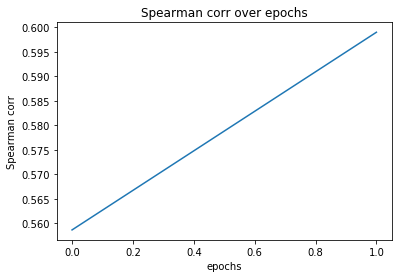

In [11]:
plt.plot(spearman_measure.scores)
plt.title("Spearman corr over epochs")
plt.xlabel("epochs")
plt.ylabel("Spearman corr");

In [20]:
encoder = Model(x, z_mean)
sample_points=data_set_size

sample_size=batch_size*int(len(test_data_plus)/batch_size)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH#82
digit_size = len(ORDER_LIST)

Text(0.5,1,'one hot encoding of input sequence (wt(red))')

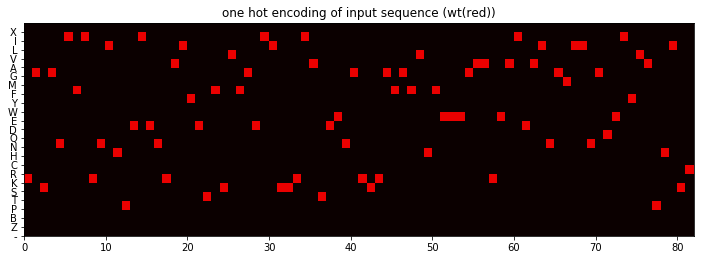

In [46]:
fig = plt.figure(figsize=(12,18))

fig.add_subplot(411)

plt.pcolor(test_data_plus[0].reshape(digit_size,sequence_size),cmap="hot",vmin=0,vmax=3)

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("one hot encoding of input sequence (wt(red))")


Text(0.5,1,'one hot encoding of recontruction sequence (wt(red))')

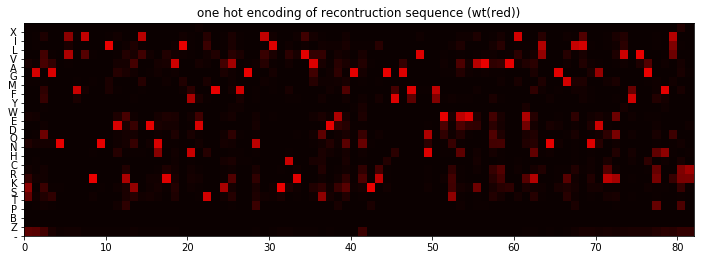

In [54]:
x_decoded=vae.predict(test_data_plus[0:1000],batch_size=batch_size)
digit_wt = x_decoded[0].reshape(digit_size,sequence_size)#24*82
fig = plt.figure(figsize=(12,18))

fig.add_subplot(411)

plt.pcolor(digit_wt.reshape(digit_size,sequence_size),cmap="hot",vmin=0,vmax=3)

plt.xlim(0,82);
plt.ylim(0,24);
plt.yticks(range(24),ORDER_LIST)

plt.title("one hot encoding of recontruction sequence (wt(red))")
